# Medium Article Recommendation

`In this work, a simple Article Recommendation System was developed using a similarity ranking method to suggest articles based on content relevance. The project involves the following steps:`
- `Text Preprocessing`
- `Text Contraction`
- `Lemmatization`
- `Bag of Words`
- `TF IDF`

In [145]:
import numpy as np
import pandas as  pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import re
import contractions

In [18]:
plt.rcParams['figure.figsize'] = [12, 6]
print('\033[34m', 'Sets the default figure size for this notebook')

In [2]:
raw_data = pd.read_csv(r'F:\Muthu_2023\Personal\NextStep\NLP\NLP\Dataset\medium_articles_v3.csv')
raw_data.head()

,link,title,sub_title,author,reading_time,text,id
0,https://towardsdatascience.com/ensemble-method...,"Ensemble methods: bagging, boosting and stacking",Understanding the key concepts of ensemble lea...,Joseph Rocca,20,This post was co-written with Baptiste Rocca.\...,1
1,https://towardsdatascience.com/understanding-a...,Understanding AUC - ROC Curve,"In Machine Learning, performance measurement i...",Sarang Narkhede,5,"In Machine Learning, performance measurement i...",2
2,https://towardsdatascience.com/how-to-work-wit...,How to work with object detection datasets in ...,"A comprehensive guide to defining, loading, ex...",Eric Hofesmann,10,Microsoft's Common Objects in Context dataset ...,3
3,https://towardsdatascience.com/11-dimensionali...,11 Dimensionality reduction techniques you sho...,Reduce the size of your dataset while keeping ...,Rukshan Pramoditha,16,"In both Statistics and Machine Learning, the n...",4
4,https://towardsdatascience.com/the-time-series...,The Time Series Transformer,Attention Is All You Need they said. Is it a m...,Theodoros Ntakouris,6,Attention Is All You Need they said. Is it a m...,5


In [24]:
raw_data.describe(include = 'all')

,link,title,sub_title,author,reading_time,text,id
count,208,208,208,208,208.000000,208,208.000000
unique,208,208,204,179,NaN,208,NaN
top,https://towardsdatascience.com/ensemble-method...,"Ensemble methods: bagging, boosting and stacking",Update: This article is part of a series. Chec...,Adam Geitgey,NaN,This post was co-written with Baptiste Rocca.\...,NaN
freq,1,1,4,5,NaN,1,NaN
mean,NaN,NaN,NaN,NaN,12.375000,NaN,107.091346
std,NaN,NaN,NaN,NaN,13.880224,NaN,62.575453
min,NaN,NaN,NaN,NaN,2.000000,NaN,1.000000
25%,NaN,NaN,NaN,NaN,6.000000,NaN,52.750000
50%,NaN,NaN,NaN,NaN,9.000000,NaN,107.500000
75%,NaN,NaN,NaN,NaN,13.000000,NaN,162.250000


- `Median reading time is 9 mins and Reading time of 75% of articles is 13 mins`
- `Four duplicates exists`
- `179 authors wrote 208 articles`

In [25]:
raw_data.isna().sum()

link            0
title           0
sub_title       0
author          0
reading_time    0
text            0
id              0
dtype: int64

# 1. Exploratory Data Analysis

In [3]:
## Author
raw_data['author'].value_counts()

author
Adam Geitgey            5
Joseph Rocca            3
Natassha Selvaraj       3
Chris Zaire             2
Dario Radecic           2
                       ..
Matt Fogel              1
Maxime                  1
Tatev Karen             1
David Sumpter           1
Dr. Stephanie Estima    1
Name: count, Length: 179, dtype: int64

`An author wrote 'Adam Geitgey' wrote the maximum number of articles`

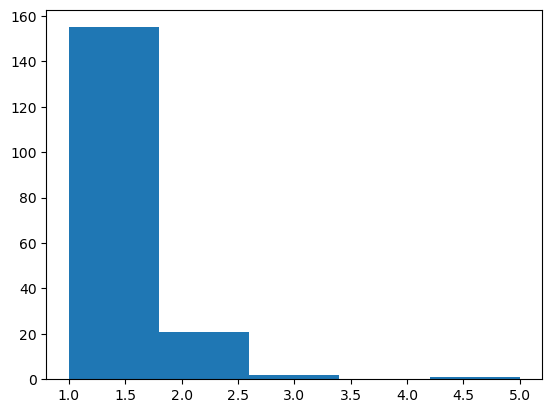

In [8]:
plt.hist(raw_data['author'].value_counts(), bins = 5);

`Majority of the authors wrote only one article`

<BarContainer object of 35 artists>

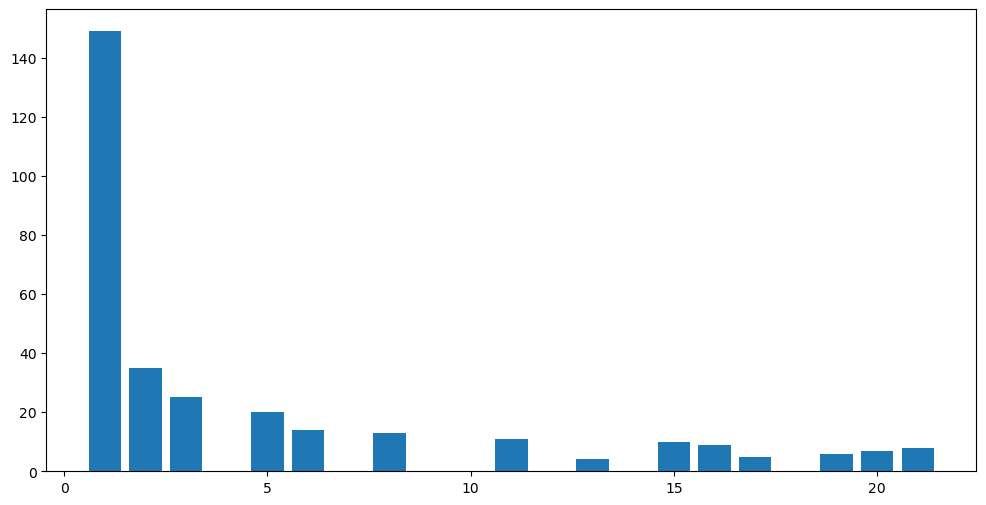

In [14]:
plt.figure(figsize=(12,6))
plt.bar(raw_data['reading_time'].value_counts(), height = list(raw_data['reading_time'].value_counts().index))

Text(0.5, 1.0, 'Relationship between No. of words and Reading time')

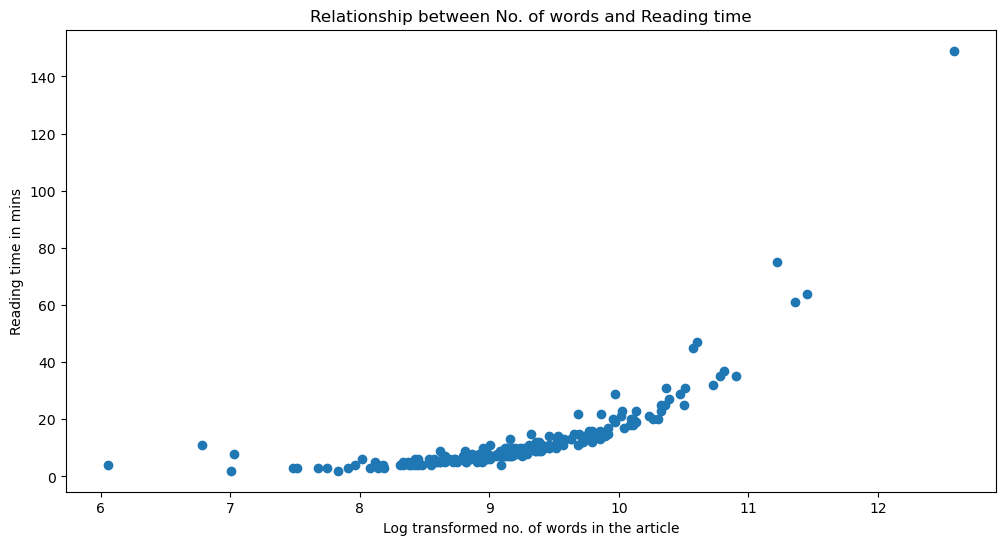

In [19]:
plt.scatter(np.log(raw_data['text'].apply(len)), raw_data['reading_time'])
plt.xlabel('No. of words in the article - Log transformed ')
plt.ylabel('Reading time in mins')
plt.title('Relationship between No. of words and Reading time');

`No of words in the article body is linearly related to the Reading time and are highly correlated`

In [21]:
print('Correlation Coeff: ', raw_data['reading_time'].corr(raw_data['text'].apply(len)))

Correlation Coeff:  0.9570411346175187


# 2. Text Preprocessing

- `Apply contractions`
- `Stop Word Removal`
- `Remove punctuations`
- `Word Tokenization`
- `Stemming/Lemmatizing`
- `Case specific Pre Processing`

In [44]:
sw = stopwords.words('english')

In [146]:
def PreProcessing(text):
    text = re.sub(r'https://[^\s\n\r]+', '', text) #Remove links
    text = re.sub(r'http://[^\s\n\r]+', '', text)
    tokens = word_tokenize(expand_contractions(text))
    word_list = []
    lemma = WordNetLemmatizer()
    for word in tokens:
        if word not in sw and word not in string.punctuation:
            word_list.append(lemma.lemmatize(word, 'v'))
    return word_list

In [42]:
def expand_contractions(text):
    word_list = []
    for word in text.split():
        word_list.append(contractions.fix(word).lower())
    return ' '.join(word_list)

In [384]:
data = raw_data.copy()
data['text_list'] = data['text'].apply(PreProcessing)
print('\033[34m', 'Cleaning of article and lemmatization performed on the text')

 Cleaning of article and lemmatization performed on the text


In [385]:
data['text_processed'] = data['text_list'].apply(lambda x: ' '.join(x))
print('\033[34m', 'Merging the list of processed words to sentence')

 Merging the list of processed words to sentence


In [386]:
voc_list = list(set(data[['id', 'text_list']].explode('text_list')['text_list']))
print('\033[34m', 'Generates unique list of vocabulary from the corpus')

 Generates unique list of vocabulary from the corpus


# 3. Bag Of Words

## 3.1. BoW from Scratch

In [281]:
bog = []
for item in data['text_list']:
    d = dict([(v, 0) for v in voc_list])
    for word in item:
        d[word] += 1
    bog.append(d)
print('\033[34m', 'Generated Bag of Words from the article text')

In [282]:
bog_df = pd.DataFrame(bog)
bog_df['Article_title'] = data['title']
bog_df['sub_title'] = data['sub_title']
bog_df['Article_ID'] = data['id']
bog_df.head()

,parisnicolas,follet,ghostweather,willingness,cold,sentimentality,csu,expiration,zuken,engineernithum,...,3500,0.33,dudfield,raji,gower,hard,matrices,Article_title,sub_title,Article_ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"Ensemble methods: bagging, boosting and stacking",Understanding the key concepts of ensemble lea...,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Understanding AUC - ROC Curve,"In Machine Learning, performance measurement i...",2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,How to work with object detection datasets in ...,"A comprehensive guide to defining, loading, ex...",3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,11 Dimensionality reduction techniques you sho...,Reduce the size of your dataset while keeping ...,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,The Time Series Transformer,Attention Is All You Need they said. Is it a m...,5


In [283]:
print('\033[34m','No. of Words: ', bog_df.shape[1]-3)

No. of Words:  30199


## 3.2. BoW using SKlearn

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

In [95]:
cv = CountVectorizer()
bog_vec = cv.fit_transform(data['text_processed'])
bog_vec.toarray().shape

In [261]:
bog_vec_df = pd.DataFrame(data = bog_vec.toarray(), columns = list(cv.get_feature_names_out()))
bog_vec_df['Article_title'] = data['title']
bog_vec_df['sub_title'] = data['sub_title']
bog_vec_df['Article_ID'] = data['id']
bog_vec_df.head()

,00,000,0000,000000,000159,00075,000mg,000th,001,0015,...,zurichneda,zurichnicolas,zuur,zwanziger,zwinderman,zylberberg,zzdata,Article_title,sub_title,Article_ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"Ensemble methods: bagging, boosting and stacking",Understanding the key concepts of ensemble lea...,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Understanding AUC - ROC Curve,"In Machine Learning, performance measurement i...",2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,How to work with object detection datasets in ...,"A comprehensive guide to defining, loading, ex...",3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11 Dimensionality reduction techniques you sho...,Reduce the size of your dataset while keeping ...,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,The Time Series Transformer,Attention Is All You Need they said. Is it a m...,5


In [269]:
print('No. of Words: ', len(cv.vocabulary_))

No. of Words:  27454


`Count Vectorizer from sk learn Performs additional preprocessing such as Stopwords and unnecessary words removal`

In [388]:
x = list(bog[0].keys())
y = list(cv.vocabulary_.keys())

In [389]:
missing_words = [item for item in x if item not in y]
print('\033[34m','Words preprocessed or removed by CountVectorizer: ',len(missing_words))

 Words preprocessed or removed by CountVectorizer:  4367


## 3.3. PCA

In [187]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [198]:
pl = Pipeline([
    ('Scaling', MinMaxScaler()),
    ('PCA', PCA(n_components=2))
])

In [284]:
pca_out1 = pl.fit_transform(bog_df.drop(['Article_title', 'sub_title'],axis = 1))
pca_out2 = pl.fit_transform(bog_vec_df.drop(['Article_title', 'sub_title'],axis = 1))

Text(0.5, 1.0, 'Bag of Words using Count Vectorizer')

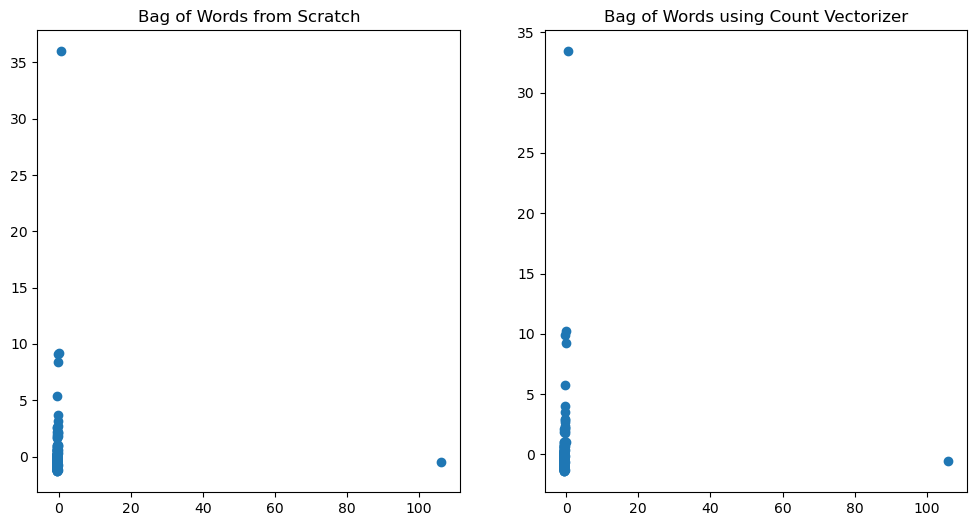

In [285]:
plt.subplot(1,2,1)
plt.scatter(pca_out1[:,0], pca_out1[:,1])
plt.title('Bag of Words from Scratch')
plt.subplot(1,2,2)
plt.scatter(pca_out2[:,0], pca_out2[:,1])
plt.title('Bag of Words using Count Vectorizer')

`Inference:`
- `No much difference noticed between BoW scratch and BoW Sklearn`
- `Some outlier articles exist`

## Cosine Distance

In [201]:
from sklearn.metrics.pairwise import cosine_similarity

In [263]:
cos_dist = cosine_similarity(bog_vec_df.drop(['Article_title', 'sub_title', 'Article_ID'], axis=1))

In [264]:
cos_dist_df = pd.DataFrame(data = cos_dist, columns = bog_vec_df['Article_title'], index = bog_vec_df['Article_title'])
cos_dist_df.head()

Article_title,"Ensemble methods: bagging, boosting and stacking",Understanding AUC - ROC Curve,How to work with object detection datasets in COCO format,11 Dimensionality reduction techniques you should know in 2021,The Time Series Transformer,Learning a Personalized Homepage,6 Data Science Certificates To Level Up Your Career,"Transformers Explained Visually (Part 2): How it works, step-by-step",60 Python Projects with Source Code,Geometric foundations of Deep Learning,...,How I lost 10kg in 60 days: My 7-step weight loss plan,The Foo Fighters' AIDS denialism should be on the record,The Uncut History of Male Circumcision,10 Things You Can Do This Morning To Heal Your Anxiety,I just lost 100 pounds. Here's whyalmost nobody else will!,Type 2 Diabetes Reversal The Quick Start Guide,How a 22 Day Water Fast Changed My Life,Breaking Your Fast,11 Unusual Tips for How to Wake Up Early,The 3 Biggest Mistakes Women Make On The Ketogenic Diet (And How To Fix Them)
Article_title,,,,,,,,,,,,,,,,,,,,,
"Ensemble methods: bagging, boosting and stacking",1.000000,0.266113,0.355630,0.326083,0.314803,0.170497,0.168766,0.164119,0.046358,0.206376,...,0.122140,0.063432,0.073135,0.127008,0.165483,0.082050,0.118237,0.077495,0.127039,0.112632
Understanding AUC - ROC Curve,0.266113,1.000000,0.152939,0.205215,0.155858,0.076257,0.077766,0.082185,0.016535,0.104065,...,0.074316,0.031882,0.055648,0.086111,0.091551,0.080861,0.060887,0.042679,0.082763,0.077148
How to work with object detection datasets in COCO format,0.355630,0.152939,1.000000,0.303899,0.220850,0.131522,0.186816,0.093446,0.112095,0.153908,...,0.099952,0.049788,0.050360,0.130217,0.137442,0.075959,0.111425,0.072249,0.118482,0.109979
11 Dimensionality reduction techniques you should know in 2021,0.326083,0.205215,0.303899,1.000000,0.372986,0.193815,0.228568,0.139009,0.085742,0.236942,...,0.098371,0.077778,0.062830,0.111103,0.134592,0.078812,0.105687,0.060696,0.110074,0.088260
The Time Series Transformer,0.314803,0.155858,0.220850,0.372986,1.000000,0.170908,0.252738,0.401367,0.061799,0.292884,...,0.238845,0.099671,0.095554,0.175302,0.278866,0.126082,0.188496,0.133741,0.298456,0.160470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Type 2 Diabetes Reversal The Quick Start Guide,0.082050,0.080861,0.075959,0.078812,0.126082,0.092065,0.109679,0.052429,0.029192,0.091999,...,0.305892,0.114082,0.097306,0.219454,0.393246,1.000000,0.322052,0.270981,0.246299,0.256466
How a 22 Day Water Fast Changed My Life,0.118237,0.060887,0.111425,0.105687,0.188496,0.148411,0.152747,0.078753,0.055022,0.143369,...,0.374547,0.156687,0.143537,0.343231,0.458822,0.322052,1.000000,0.602881,0.323589,0.301297
Breaking Your Fast,0.077495,0.042679,0.072249,0.060696,0.133741,0.097977,0.071440,0.059375,0.035541,0.098285,...,0.268891,0.095029,0.091980,0.201920,0.356840,0.270981,0.602881,1.000000,0.249349,0.289274


In [246]:
def get_topn_recommendations(df, n, title):
    return df[title].sort_values(ascending=False).index[1:n]

In [395]:
cos_dist = cosine_similarity(bog_df.drop(['Article_title', 'sub_title', 'Article_ID'], axis=1))
cos_dist_bog_df = pd.DataFrame(data = cos_dist, columns = bog_df['Article_title'], index = bog_df['Article_title'])
cos_dist_bog_df.head()

Article_title,"Ensemble methods: bagging, boosting and stacking",Understanding AUC - ROC Curve,How to work with object detection datasets in COCO format,11 Dimensionality reduction techniques you should know in 2021,The Time Series Transformer,Learning a Personalized Homepage,6 Data Science Certificates To Level Up Your Career,"Transformers Explained Visually (Part 2): How it works, step-by-step",60 Python Projects with Source Code,Geometric foundations of Deep Learning,...,How I lost 10kg in 60 days: My 7-step weight loss plan,The Foo Fighters' AIDS denialism should be on the record,The Uncut History of Male Circumcision,10 Things You Can Do This Morning To Heal Your Anxiety,I just lost 100 pounds. Here's whyalmost nobody else will!,Type 2 Diabetes Reversal The Quick Start Guide,How a 22 Day Water Fast Changed My Life,Breaking Your Fast,11 Unusual Tips for How to Wake Up Early,The 3 Biggest Mistakes Women Make On The Ketogenic Diet (And How To Fix Them)
Article_title,,,,,,,,,,,,,,,,,,,,,
"Ensemble methods: bagging, boosting and stacking",1.000000,0.252102,0.354580,0.325972,0.297564,0.176054,0.176768,0.187708,0.046669,0.239616,...,0.152468,0.134004,0.138686,0.165334,0.208361,0.094539,0.137356,0.083171,0.140702,0.153435
Understanding AUC - ROC Curve,0.252102,1.000000,0.157029,0.199030,0.164313,0.075625,0.079338,0.091433,0.016495,0.103381,...,0.073916,0.033361,0.051468,0.092020,0.090101,0.084412,0.060076,0.043528,0.086564,0.076712
How to work with object detection datasets in COCO format,0.354580,0.157029,1.000000,0.318179,0.222089,0.134368,0.188285,0.103860,0.101495,0.149762,...,0.100052,0.051349,0.053336,0.133650,0.136203,0.077640,0.112810,0.070763,0.121901,0.112212
11 Dimensionality reduction techniques you should know in 2021,0.325972,0.199030,0.318179,1.000000,0.362574,0.194450,0.220123,0.147486,0.077197,0.205650,...,0.104130,0.072998,0.063311,0.120378,0.136238,0.087048,0.112388,0.062322,0.116550,0.096204
The Time Series Transformer,0.297564,0.164313,0.222089,0.362574,1.000000,0.172554,0.251659,0.389931,0.059806,0.275042,...,0.229144,0.077730,0.084773,0.175969,0.259715,0.138856,0.185677,0.130919,0.294137,0.157128


In [393]:
inds = get_topn_recommendations(cos_dist_bog_df, 10, '11 Dimensionality reduction techniques you should know in 2021')
print('\033[34m','Results of SKlearn vectorizer:')
for item in list(inds):
    print('\033[90m', '- ', item)

 Results of SKlearn vectorizer:
 -  PCA using Python (scikit-learn)
 -  Building RNN, LSTM, and GRU for time series using PyTorch
 -  Visualising high-dimensional datasets using PCA and t-SNE in Python
 -  Random Forest in Python
 -  Fundamental Techniques of Feature Engineering for Machine Learning
 -  Detecting Credit Card Fraud Using Machine Learning
 -  Hyperparameter Tuning the Random Forest in Python
 -  What to do with "small" data?
 -  A One-Stop Shop for Principal Component Analysis


In [394]:
inds = get_topn_recommendations(cos_dist_df, 10, '11 Dimensionality reduction techniques you should know in 2021')
print('\033[34m','Results of BoW Scratch Implementation:')
for item in list(inds):
    print('\033[90m', '- ', item)

 Results of BoW Scratch Implementation:
 -  PCA using Python (scikit-learn)
 -  Building RNN, LSTM, and GRU for time series using PyTorch
 -  Visualising high-dimensional datasets using PCA and t-SNE in Python
 -  Random Forest in Python
 -  Fundamental Techniques of Feature Engineering for Machine Learning
 -  A One-Stop Shop for Principal Component Analysis
 -  Detecting Credit Card Fraud Using Machine Learning
 -  OVER 100 Data Scientist Interview Questions and Answers!
 -  Hyperparameter Tuning the Random Forest in Python


`Inference:`
- `Results are similar for randomly choosen sample`
- `Checking multiple samples would help`

# TF-IDF

In [322]:
# sample = ['it was the best of times', 'it was the worst of times', 'it was the age of wisdom and the age of foolishness']
# voc = set()
# for text in sample:
#     for word in text.split():
#         voc.add(word)
# voc = list(voc)
# voc

In [396]:
d_idf = dict((v,0) for v in voc_list)
n = len(data['text_processed'])
for word in voc_list:
    for text in data['text_processed']:
        if word in text:
            d_idf[word] += 1
    d_idf[word] = np.log(n / d_idf[word])
print('\033[34m','Generates Inverse Document Frequence for each word and store it in dictionary')

 Generates Inverse Document Frequence for each word and store it in dictionary


In [397]:
tf = []
for text in data['text_list']:
    d = dict((v,0) for v in voc_list)
    cnt_words = 0
    for word in text:
        cnt_words += 1
        d[word] += 1
    if cnt_words != 0:
        for key in d.keys():
            d[key] /= cnt_words
            d[key] *= d_idf[key]
    tf.append(d)
    
print('\033[34m','Calculates TF-IDF for each word in each article')

 Calculates TF-IDF for each word in each article


In [353]:
tfidf_df = pd.DataFrame(tf)
tfidf_df['Article_title'] = data['title']
tfidf_df.head()

,parisnicolas,follet,ghostweather,willingness,cold,sentimentality,csu,expiration,zuken,engineernithum,...,constipation,quebec-based,3500,0.33,dudfield,raji,gower,hard,matrices,Article_title
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"Ensemble methods: bagging, boosting and stacking"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Understanding AUC - ROC Curve
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000729,0.0,How to work with object detection datasets in ...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000436,0.0,11 Dimensionality reduction techniques you sho...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,The Time Series Transformer


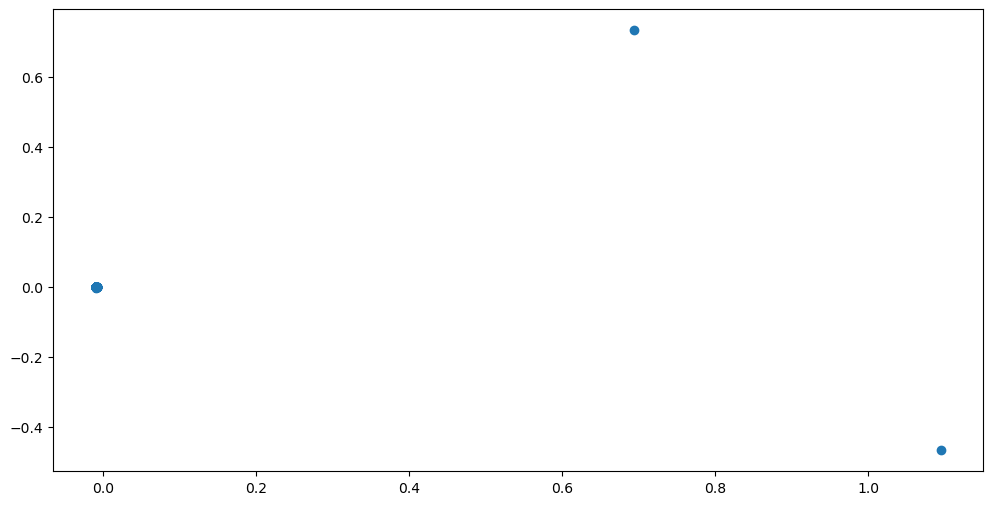

In [355]:
pca = PCA()
pca_out1 = pca.fit_transform(tfidf_df.drop(['Article_title'], axis=1))
plt.scatter(pca_out1[:,0], pca_out1[:,1])
plt.xlim(0, 0.01)

In [357]:
pca_out1

array([[-8.85898980e-03, -1.33862671e-03, -3.25019251e-03, ...,
        -3.34740001e-04, -9.94829299e-04,  7.54476899e-16],
       [-8.70200903e-03, -1.57996544e-03, -3.59633233e-03, ...,
         3.76273438e-05, -5.80132257e-06,  7.54476899e-16],
       [-9.08045782e-03, -1.42274891e-03, -3.65419573e-03, ...,
        -1.14142283e-05,  2.22716263e-05,  7.54476899e-16],
       ...,
       [-8.59630565e-03, -1.22600066e-03, -2.38401797e-03, ...,
         8.15259045e-04, -6.21436890e-05,  7.54476899e-16],
       [-8.51504859e-03, -1.22220233e-03, -1.78610419e-03, ...,
         1.13091142e-03,  6.95164594e-05,  7.54476899e-16],
       [-8.62598098e-03, -1.26094930e-03, -2.24011692e-03, ...,
         4.37105726e-04, -5.80913624e-05,  7.54476899e-16]])

`Further analysis required, as the results are not convincing`

## TFIDF Vectorizer - SKLearn

In [359]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [360]:
tfidf_vec = TfidfVectorizer()
tfidf_out = tfidf_vec.fit_transform(data['text_processed'])

In [363]:
tfidf_out.toarray().shape

(208, 27454)

In [368]:
tfidf_vec_df = pd.DataFrame(data = tfidf_out.toarray(), columns = tfidf_vec.get_feature_names_out())
tfidf_vec_df['Article_title'] = data['title']
tfidf_vec_df.head()

,00,000,0000,000000,000159,00075,000mg,000th,001,0015,...,zurichmandu,zurichmara,zurichneda,zurichnicolas,zuur,zwanziger,zwinderman,zylberberg,zzdata,Article_title
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Ensemble methods: bagging, boosting and stacking"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Understanding AUC - ROC Curve
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,How to work with object detection datasets in ...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11 Dimensionality reduction techniques you sho...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The Time Series Transformer


In [370]:
pca_out4 = pca.fit_transform(tfidf_vec_df.drop(['Article_title'], axis=1))

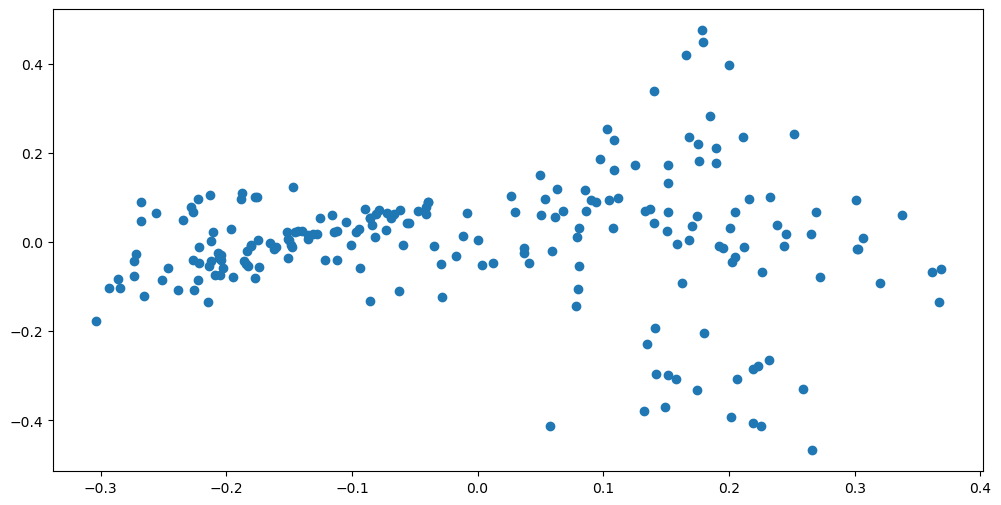

In [371]:
plt.scatter(pca_out4[:,0], pca_out4[:,1])

`Inference:`
- `Clusters are visible in the PCA components`
- `Interactive plot helps to gather insights about the clusters`

## Cosine Distance

In [372]:
cos_dist_idf_vec = cosine_similarity(tfidf_vec_df.drop(['Article_title'], axis=1))
cos_dist_idf_vec.shape

(208, 208)

In [373]:
cos_dist_idf_vec_df = pd.DataFrame(data = cos_dist_idf_vec, columns = tfidf_vec_df['Article_title'], index = tfidf_vec_df['Article_title'])
cos_dist_idf_vec_df.head()

Article_title,"Ensemble methods: bagging, boosting and stacking",Understanding AUC - ROC Curve,How to work with object detection datasets in COCO format,11 Dimensionality reduction techniques you should know in 2021,The Time Series Transformer,Learning a Personalized Homepage,6 Data Science Certificates To Level Up Your Career,"Transformers Explained Visually (Part 2): How it works, step-by-step",60 Python Projects with Source Code,Geometric foundations of Deep Learning,...,How I lost 10kg in 60 days: My 7-step weight loss plan,The Foo Fighters' AIDS denialism should be on the record,The Uncut History of Male Circumcision,10 Things You Can Do This Morning To Heal Your Anxiety,I just lost 100 pounds. Here's whyalmost nobody else will!,Type 2 Diabetes Reversal The Quick Start Guide,How a 22 Day Water Fast Changed My Life,Breaking Your Fast,11 Unusual Tips for How to Wake Up Early,The 3 Biggest Mistakes Women Make On The Ketogenic Diet (And How To Fix Them)
Article_title,,,,,,,,,,,,,,,,,,,,,
"Ensemble methods: bagging, boosting and stacking",1.000000,0.080043,0.126710,0.163837,0.138658,0.067184,0.061308,0.093963,0.022573,0.080793,...,0.049111,0.015616,0.017975,0.039911,0.069387,0.023729,0.047731,0.026556,0.040780,0.033881
Understanding AUC - ROC Curve,0.080043,1.000000,0.032950,0.080930,0.043496,0.019016,0.018845,0.035955,0.005682,0.034181,...,0.018442,0.006729,0.014023,0.023765,0.029227,0.030016,0.020866,0.017679,0.018552,0.016344
How to work with object detection datasets in COCO format,0.126710,0.032950,1.000000,0.126716,0.058249,0.036262,0.052527,0.025452,0.060796,0.047798,...,0.023552,0.009250,0.008649,0.030811,0.035687,0.016927,0.027668,0.024870,0.026221,0.024620
11 Dimensionality reduction techniques you should know in 2021,0.163837,0.080930,0.126716,1.000000,0.188886,0.092178,0.072171,0.059814,0.053131,0.105343,...,0.035288,0.019911,0.016013,0.037330,0.051287,0.025130,0.035680,0.019126,0.034766,0.025887
The Time Series Transformer,0.138658,0.043496,0.058249,0.188886,1.000000,0.059839,0.081716,0.338665,0.022635,0.133670,...,0.074410,0.025312,0.019167,0.054685,0.111525,0.033081,0.063127,0.038523,0.087661,0.047068


In [375]:
cos_dist_idf = cosine_similarity(tfidf_df.drop(['Article_title'], axis=1))
cos_dist_idf_df = pd.DataFrame(data = cos_dist_idf, columns = tfidf_df['Article_title'], index = tfidf_df['Article_title'])
cos_dist_idf_df.head()


Article_title,"Ensemble methods: bagging, boosting and stacking",Understanding AUC - ROC Curve,How to work with object detection datasets in COCO format,11 Dimensionality reduction techniques you should know in 2021,The Time Series Transformer,Learning a Personalized Homepage,6 Data Science Certificates To Level Up Your Career,"Transformers Explained Visually (Part 2): How it works, step-by-step",60 Python Projects with Source Code,Geometric foundations of Deep Learning,...,How I lost 10kg in 60 days: My 7-step weight loss plan,The Foo Fighters' AIDS denialism should be on the record,The Uncut History of Male Circumcision,10 Things You Can Do This Morning To Heal Your Anxiety,I just lost 100 pounds. Here's whyalmost nobody else will!,Type 2 Diabetes Reversal The Quick Start Guide,How a 22 Day Water Fast Changed My Life,Breaking Your Fast,11 Unusual Tips for How to Wake Up Early,The 3 Biggest Mistakes Women Make On The Ketogenic Diet (And How To Fix Them)
Article_title,,,,,,,,,,,,,,,,,,,,,
"Ensemble methods: bagging, boosting and stacking",1.000000,0.033858,0.064811,0.089483,0.065715,0.044034,0.025527,0.068468,0.012774,0.040193,...,0.022477,0.006951,0.005865,0.013893,0.032968,0.008389,0.021973,0.010113,0.010196,0.011953
Understanding AUC - ROC Curve,0.033858,1.000000,0.014284,0.043110,0.015219,0.009421,0.006588,0.031758,0.003096,0.016765,...,0.004723,0.003843,0.006720,0.012154,0.013913,0.021626,0.011465,0.016966,0.004026,0.006415
How to work with object detection datasets in COCO format,0.064811,0.014284,1.000000,0.066995,0.020136,0.020334,0.020196,0.011913,0.041157,0.023903,...,0.007349,0.003559,0.002872,0.009597,0.013197,0.006004,0.007665,0.012009,0.005756,0.010340
11 Dimensionality reduction techniques you should know in 2021,0.089483,0.043110,0.066995,1.000000,0.092690,0.045114,0.019940,0.032790,0.034577,0.048779,...,0.012108,0.006672,0.003757,0.013610,0.018875,0.008402,0.009696,0.005409,0.008871,0.009336
The Time Series Transformer,0.065715,0.015219,0.020136,0.092690,1.000000,0.032439,0.023975,0.268403,0.006990,0.065598,...,0.019446,0.007869,0.004784,0.019183,0.052012,0.009397,0.017482,0.009882,0.021904,0.014854


In [399]:
inds = get_topn_recommendations(cos_dist_idf_df, 10, '11 Dimensionality reduction techniques you should know in 2021')
print('\033[34m','Results of TFIDF scratch Implementation:')
for item in list(inds):
    print('\033[90m', '- ', item)

 Results of TFIDF scratch Implementation:
 -  PCA using Python (scikit-learn)
 -  A One-Stop Shop for Principal Component Analysis
 -  Visualising high-dimensional datasets using PCA and t-SNE in Python
 -  A Comprehensive Guide to Convolutional Neural Networks  the ELI5 way
 -  Building RNN, LSTM, and GRU for time series using PyTorch
 -  Hyperparameter Tuning the Random Forest in Python
 -  Fundamental Techniques of Feature Engineering for Machine Learning
 -  OVER 100 Data Scientist Interview Questions and Answers!
 -  Random Forest in Python


In [400]:
inds = get_topn_recommendations(cos_dist_idf_vec_df, 10, '11 Dimensionality reduction techniques you should know in 2021')
print('\033[34m','Results of TFIDF Vectorizer Implementation:')
for item in list(inds):
    print('\033[90m', '- ', item)

 Results of TFIDF Vectorizer Implementation:
 -  PCA using Python (scikit-learn)
 -  Visualising high-dimensional datasets using PCA and t-SNE in Python
 -  A One-Stop Shop for Principal Component Analysis
 -  Building RNN, LSTM, and GRU for time series using PyTorch
 -  Fundamental Techniques of Feature Engineering for Machine Learning
 -  Random Forest in Python
 -  Simple and Multiple Linear Regression in Python
 -  A Comprehensive Guide to Convolutional Neural Networks  the ELI5 way
 -  OVER 100 Data Scientist Interview Questions and Answers!


`Inference:`
- `Results of TFIDF vectorizer is efficient`
- `TFIDF outperforms BoW`
- `As no labels are available, could not apply any metric`

# Prepared by Muthukumar G